## Pathfinder: Script README

Main pathfinding script. 

### Inputs
- Player ID: esbid of the player we want to measure ball carrier vision metric. Declared in the script constants
- Play DF: DF of the specific play/game that we want to analyze. Output from the play extraction script. Path declared in the script constants
- Ownership Array: Ownership data for the play, at each specified timestamp. Output from the main ownership model

### Outputs
- Ball Carrier Vision Metric, at every specified timestamp
- Field visualization of optimized path vs actual path, as seen on the ownership field

### Notes
Script currently calculates the ball carrier metric at the following timestamps:

[start_time, start_time+2, start_time+5, handoff_time, handoff_time+2, handoff_time+5]

Handoff time is assigned as the timestamp when RB or WR receives ball

Optimal path is determined using the Dijkstra Search algorithm. Dijkstra favors paths that cost less, where cost in the context of ball carrier pathfinding is determined by the ownership model. This allows the model to determine paths that are quick while exploiting as much owned space as possible

For both optimal and actual paths, a Path Risk Score is calculated. risk score is a simple sum of the cost of each square yard taken on the path. As the optimal path will always find a path to the endzone, an unadjusted optimal path score will always be longer than the actual path. As such, the optimal path risk score is adjusted to be the same length as the actual path i.e. what would have been the Path Risk Score had the ball carrier covered the exact same amount of distance on the optimal path?

Ball carrier metric is currently calculated as:

Score = (Actual Path Risk Score) / (Optimal Path Risk Score) 

i.e. a score of 2.1 indicates that the ball carrier took a path that was 2.1x more riskier when compared against the optimal path

In [1]:
import heapq
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict

%matplotlib inline

In [2]:
### SCRIPT CONSTANTS ###

FIELD_WIDTH = 100
FIELD_HEIGHT = 54
PLAYER_ID = 'BAR192674'
DF_PATH = 'play_dfs/playDF_249.pickle'
PLAYID = 249


In [3]:
class Field:
    """ Football field class for populating, exploring, and 
    visualizing a football field imposed with an ownership model.
    
    Attributes:
        width (int) representing the width of the football field
        height (int) representing the length of the football field
        ownership_array (2D array) 2D array containing ownership values of the football field
        optimal_path (list) list of tuples representing the optimal path of a player
        actual_path (list) list of tuples representing the actual, recorded path of a player
        optimal_path_score (float) representing the risk score of the optimal path
        actual_path_score (float) representing the risk score of the actual path 
        vision_metric (float) representing the ball carrier vision metric
            
    """
    def __init__(self, width, height, ownership_array):
        self.width = width
        self.height = height
        self.ownership_array = ownership_array
        self.optimal_path = None
        self.actual_path = None
        self.optimal_path_score = 0
        self.actual_path_score = 0
        self.vision_metric = 0
    
    def in_bounds(self, id):
        (x, y) = id
        return 0 <= x < self.width and 0 <= y < self.height
    
    def passable(self, id):
        # not currently used, as ownership model will account for player positions implicitly
        return id not in self.players
    
    def neighbors(self, id):
        (x, y) = id
        results = [(x+1, y), (x+1, y-1), (x, y-1), (x-1, y-1), (x-1, y), (x-1, y+1), (x, y+1), (x+1, y+1)]
        # results = [(x+1, y), (x, y-1), (x-1, y), (x, y+1)]
        if (x + y) % 2 == 0: results.reverse() # aesthetics
        results = filter(self.in_bounds, results)
        # results = filter(self.passable, results)
        return results
    
    def cost(self, node):
        return self.ownership_array[node[0],node[1]]
    
    def calculate_path_risk(self, path):
        risk_score = 0
        for node in path:
            risk_score += self.ownership_array[node[0],node[1]]
        return risk_score
    
    def calculate_path_scores(self):
        if self.optimal_path is None or self.actual_path is None:
            return
        self.actual_path_score = self.calculate_path_risk(self.actual_path)
        shortened_optimal_path = self.optimal_path[:len(self.actual_path)]  # to adjust to same length as actual
        self.optimal_path_score = self.calculate_path_risk(shortened_optimal_path)
        
    def calculate_vision(self):
        if self.optimal_path is None or self.actual_path is None:
            return self.vision_metric
        self.vision_metric = self.actual_path_score / self.optimal_path_score
    
    def visualize_field(self):
        plt.figure(figsize = (20,10))
        if self.optimal_path is not None:
            plt.plot(self.optimal_path[:, 0], self.optimal_path[:, 1], color='black', linestyle='dashed', linewidth=2)
        if self.actual_path is not None:
            x_val = [x[0] for x in self.actual_path]
            y_val = [x[1] for x in self.actual_path]
            plt.plot(x_val, y_val, color='black', linewidth=2)
        plt.imshow(self.ownership_array.T, cmap='bwr', origin='lower')
        plt.colorbar()

In [4]:
class PriorityQueue:
    """ Priority queue used to store nodes to calculate Dijkstra's algorithm.
        Implemented using python heapq
    
    Attributes:
        elements (list) contains nodes explored by the search algorithm
            
    """
    def __init__(self):
        self.elements = []
    
    def empty(self):
        return len(self.elements) == 0
    
    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))
    
    def get(self):
        return heapq.heappop(self.elements)[1]

In [5]:
def dijkstra_search(graph, start, goal):
    frontier = PriorityQueue()
    frontier.put(start, 0)
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0
    
    while not frontier.empty():
        current = frontier.get()
        
        #if current == goal:
            #break
        
        for next in graph.neighbors(current):
            # check for diagnoal move and weight cost accordingly
            if abs(next[0]-current[0]) + abs(next[1]-current[1]) == 2:
                new_cost = cost_so_far[current] + 1.4* graph.cost(next)
            else:
                new_cost = cost_so_far[current] + graph.cost(next)
                
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost
                frontier.put(next, priority)
                came_from[next] = current
    
    return came_from, cost_so_far 


def reconstruct_path(came_from, start, goal):
    current = goal
    path = []
    while current != start:
        path.append(current)
        current = came_from[current]
    path.append(start) # optional
    path.reverse() # optional
    return path


def shortest_endzone_path(came_from, cost_so_far, start_node, end_node):
    path_cost = cost_so_far[(end_node)]
    best_node = end_node
    endzone_x = FIELD_WIDTH - 1
    
    for i in range (FIELD_HEIGHT):
        current_cost = cost_so_far[(endzone_x, i)]
        
        if path_cost > current_cost:
            best_node = (endzone_x, i)
            path_cost = current_cost
    return reconstruct_path(came_from, start_node, best_node)


def player_pos_at_time(play_df, esbid, seconds_passed):
    playtime_0 = play_df['player_time'].min()
    playtime_target = playtime_0 + pd.Timedelta(seconds=seconds_passed)
    
    coord = play_df.loc[(play_df['player_time']==playtime_target) & (play_df['esbid']==esbid)]['rounded_coord'].values[0]
    return coord


def player_actual_path(play_df, esbid, seconds_passed):
    playtime_0 = play_df['player_time'].min()
    playtime_target = playtime_0 + pd.Timedelta(seconds=seconds_passed)
    
    path = play_df[(play_df.esbid == esbid) & (play_df.player_time >= playtime_target)]['rounded_coord'].values
    path = pd.unique(path)
    return path


def get_handoff_time(play_df):
    handoff_time = play_df[(play_df.has_ball == True) & 
                           ((play_df.position == 'RB') |
                            (play_df.position == 'WR'))]['player_time'].min()
    return handoff_time


def ownership_array_format(df_pkl):
    ownership = pd.read_pickle(df_pkl).to_numpy().T
    ownership = np.delete(ownership, -1, 0)
    ownership = np.delete(ownership, -1, 1)
    field = np.ones((FIELD_WIDTH, FIELD_HEIGHT))
    inverted_field = field - ownership
    inverted_field = np.where(inverted_field==0, 0.01, inverted_field)
    inverted_field = np.where(inverted_field==1, 0.99, inverted_field)
    return inverted_field


# testing only -- creates random ownership array
def populate_players(play_df):
    field = np.random.rand(FIELD_WIDTH, FIELD_HEIGHT)

    for coord in player_coord:
        field[coord[0],coord[1]]=1
        
    return (field)

In [6]:
def run_path_comparisons(df, playerid):
    # get time slices
    start_time = df['player_time'].min()
    end_time = df['player_time'].max()
    duration = (end_time - start_time).seconds
    handoff_time = get_handoff_time(df)
    handoff_start_delta = (handoff_time - start_time).seconds
    
    timestamps = [start_time, start_time+pd.Timedelta(seconds=2), start_time+pd.Timedelta(seconds=5),
                  handoff_time, handoff_time+pd.Timedelta(seconds=2), handoff_time+pd.Timedelta(seconds=5)]
    secs_passed = [0, 2, 5, handoff_start_delta, handoff_start_delta+2, handoff_start_delta+5]
    
    # main loop, to be run at every timestamp
    for i in range(len(timestamps)):
        # play_df = df[(df.player_time == timestamps[i])] ### testing only -- no need for all player positions
        # ownership_array = populate_players(play_df['rounded_coord'].tolist())  ### To switch with actual ownership
        
        # determine if play ended before the last timestamp of interest
        try:
            start_coords = player_pos_at_time(df, playerid, secs_passed[i])
        except IndexError:
            print("End of play")
            return
        
        
        
        # populate field with ownership model results
        ownership_array = ownership_array_format(str(PLAYID)+'_'+str(i)+'.pickle')

        field = Field(FIELD_WIDTH, FIELD_HEIGHT, ownership_array)
        
        # calculate optimal path
        came_from, cost_so_far = dijkstra_search(field, start_coords, (99,0))
        optimal_path = shortest_endzone_path(came_from, cost_so_far, start_coords, (99,0))
        field.optimal_path = np.asarray(optimal_path)
        
        # get actual path taken
        actual_path = np.asarray(list(player_actual_path(df, playerid, secs_passed[i])))       
        field.actual_path = actual_path
        
        # model outputs
        field.visualize_field()
        field.calculate_path_scores()
        field.calculate_vision()
        print('Ball Carrier Vision Metric Score ({} seconds after play-start): {:f}'
              .format(secs_passed[i], field.vision_metric))
        print(timestamps[i])

In [7]:
df = pd.read_pickle(DF_PATH)

Ball Carrier Vision Metric Score (0 seconds after play-start): 1.508577
2019-09-08 20:33:29.100000
Ball Carrier Vision Metric Score (2 seconds after play-start): 1.098043
2019-09-08 20:33:31.100000
Ball Carrier Vision Metric Score (5 seconds after play-start): 1.023981
2019-09-08 20:33:34.100000
Ball Carrier Vision Metric Score (14 seconds after play-start): 1.120275
2019-09-08 20:33:44
Ball Carrier Vision Metric Score (16 seconds after play-start): 1.121019
2019-09-08 20:33:46
Ball Carrier Vision Metric Score (19 seconds after play-start): 1.140625
2019-09-08 20:33:49


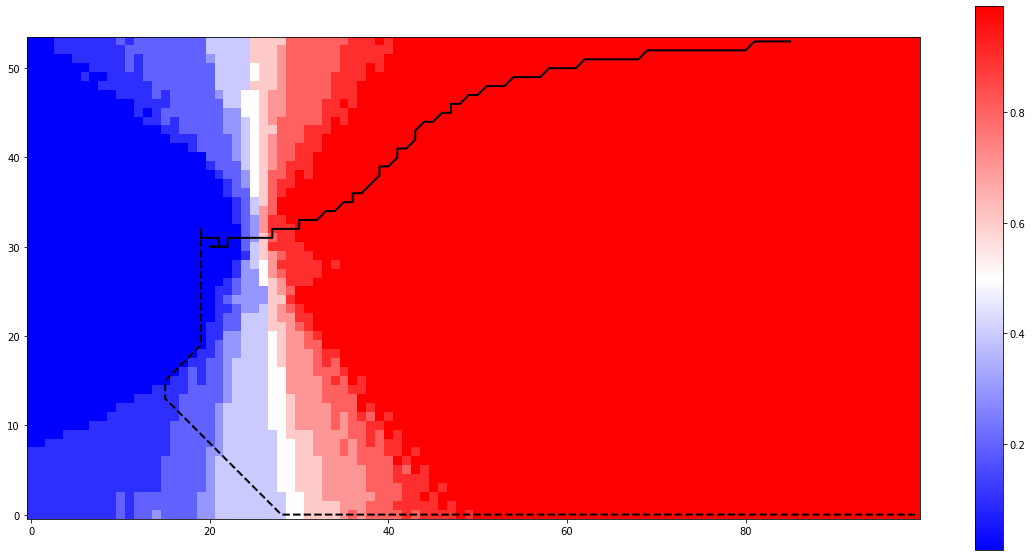

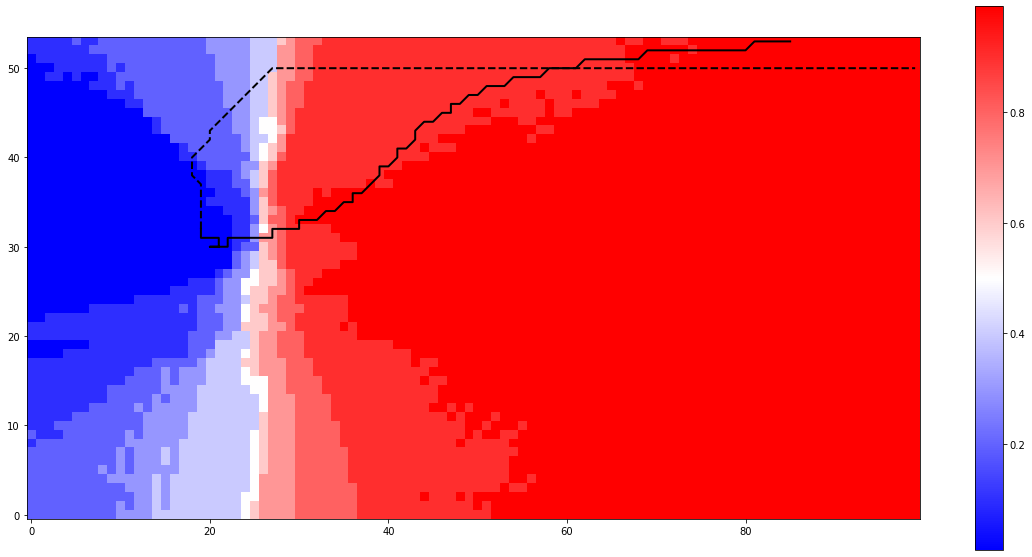

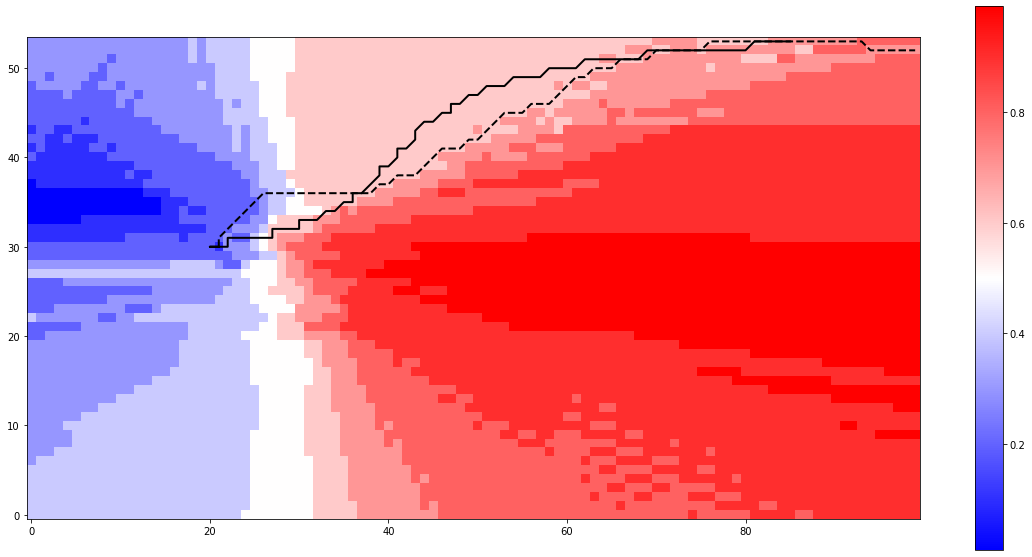

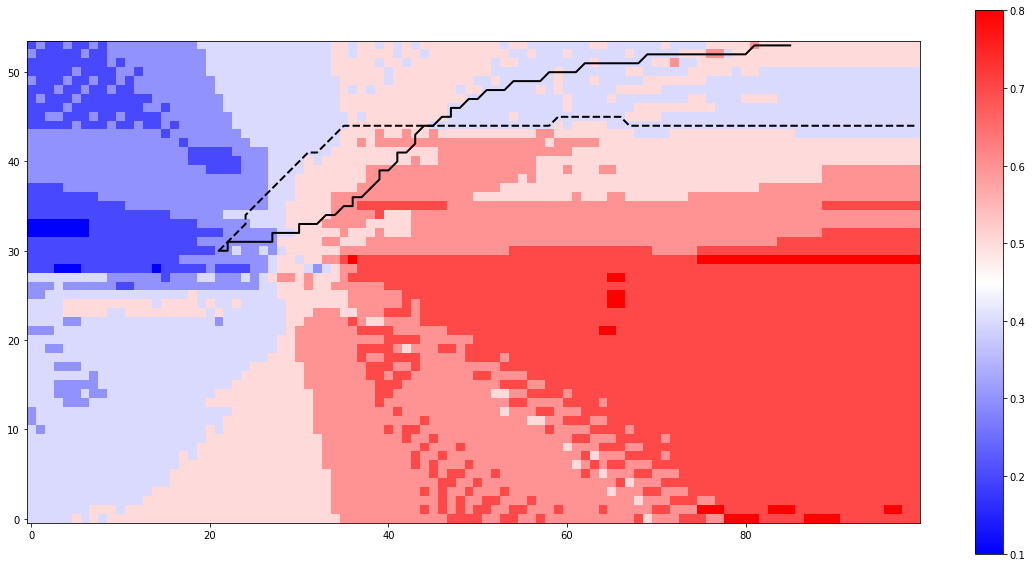

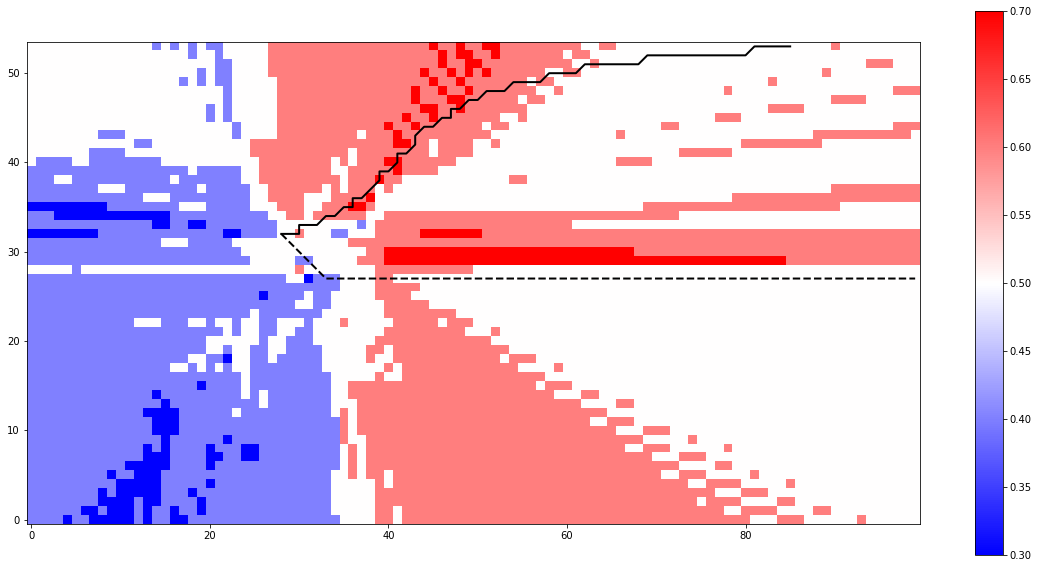

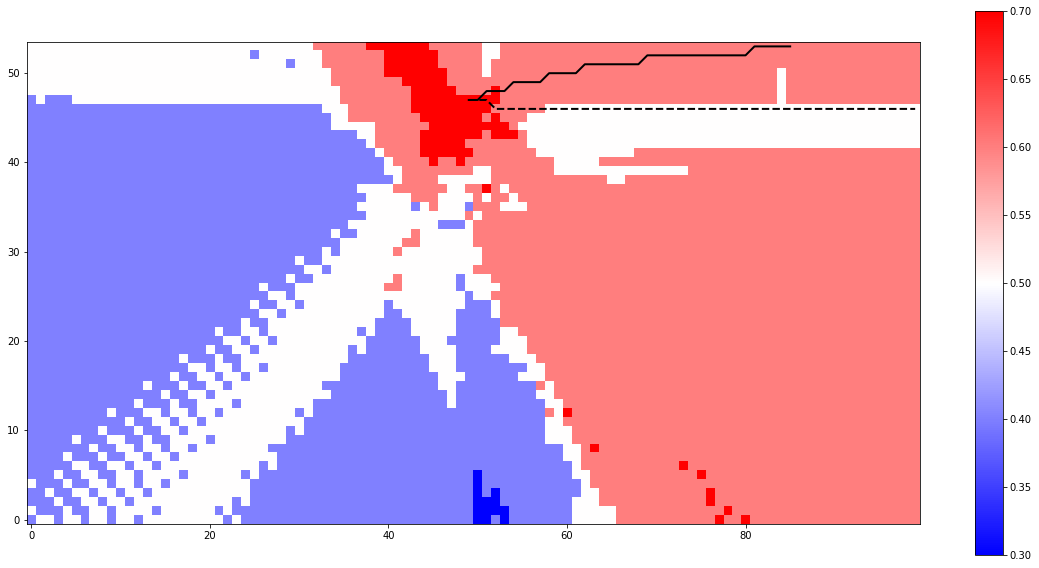

In [8]:
run_path_comparisons(df, PLAYER_ID)